# RAG Generation en TFM_RAG_NOR

## Índice


1. [Introducción y objetivos](#1-introducción-y-objetivos)
2. [Carga de datos y configuración](#2-carga-de-datos-y-configuración)
3. [Pipeline RAG: Recuperación + Generación](#3-pipeline-rag-recuperación--generación)
    - 3.1. Recuperación de chunks relevantes (Hybrid MPNet α=0.3)
    - 3.2. Construcción del prompt
    - 3.3. Generación de respuesta con LLM
    - 3.4. Visualización de resultados (respuesta + chunks)
4. [Evaluación de la generación](#4-evaluación-de-la-generación)
    - 4.1. Evaluación manual (exactitud, completitud, estilo)
    - 4.2. Evaluación automática (BERTScore y opcionalmente métricas RAGAS simples)
5. [Demo tester](#5-demo-tester) 
6. [Extensión con modelos entrenados](#6-Extensión-con-modelos-entrenados)

---

## 1. Introducción y objetivos

En este notebook se implementa la fase de generación del sistema RAG sobre el corpus de documentos normativos.  
Hasta ahora se han preparado los datos, creado los índices y evaluado diferentes métodos de recuperación. El mejor rendimiento lo dio el método híbrido BM25 + MPNet (α=0.3), que será el que se use aquí como base.

El objetivo es montar un pipeline completo de RAG (retrieval → generación), capaz de:
- Recuperar los chunks más relevantes para una query.
- Construir un prompt con esos chunks y la pregunta.
- Enviar el prompt a un LLM open-source vía API gratuita.
- Obtener una respuesta fundamentada en los documentos recuperados.
- Guardar y evaluar las respuestas generadas.

Este notebook servirá como prototipo mínimo viable de RAG, sobre el que se podrá analizar el alcance, limitaciones y posibles mejoras.

---

## 2. Carga de datos y configuración

En esta parte se importan las librerías necesarias, se cargan los datos de soporte (benchmark de preguntas y respuestas) y se configuran las claves de acceso para el modelo de lenguaje.  

También se definen las rutas de trabajo (`data/`, `results/`) y se cargan las funciones de recuperación que ya se usaron en la fase anterior para garantizar coherencia.


In [11]:
!pip install openai


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os
import json
import pandas as pd
from datetime import datetime
from openai import OpenAI

DATA_PATH = "../data/"
RESULTS_PATH = "../results/"
os.makedirs(RESULTS_PATH, exist_ok=True)

with open(os.path.join(DATA_PATH, "eval", "qa_eval_set.json"), "r", encoding="utf-8") as f:
    qa_eval_set = json.load(f)

print("Preguntas cargadas:", len(qa_eval_set))

client = OpenAI(
    api_key="api_key",
    base_url="https://api.groq.com/openai/v1"
)


Preguntas cargadas: 150


---

## 3. Pipeline RAG: Recuperación + Generación

### 3.1. Recuperación de chunks relevantes (Hybrid MPNet α=0.3)

En esta parte se reutilizan los índices creados en la fase anterior para recuperar los chunks más relevantes a partir de una query.  
Se aplicará el mismo pipeline de preprocesado y combinación híbrida (BM25 + MPNet con α=0.3) que dio los mejores resultados en la evaluación.  

El objetivo es garantizar que cualquier nueva pregunta, ya sea escrita a mano o tomada del benchmark, pase por el mismo proceso de recuperación coherente antes de la generación de respuesta.


In [13]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
import faiss
import pickle
from sentence_transformers import SentenceTransformer
import json

# BM25
with open("../data/bm25/bm25_index.pkl", "rb") as f:
    bm25 = pickle.load(f)

# FAISS MPNet
faiss_index = faiss.read_index("../data/faiss_index/faiss_index_mpnet.faiss")

# Cargar chunks y metadatos (listas)
with open("../data/chunks/texts.json", "r", encoding="utf-8") as f:
    texts = json.load(f)

with open("../data/chunks/metadata.json", "r", encoding="utf-8") as f:
    metadata = json.load(f)

# Modelo embeddings MPNet
mpnet_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

def preprocess(text):
    return text.lower().strip()

def hybrid_retrieval(query, alpha=0.3, top_k=3):
    q = preprocess(query)

    # BM25
    tokenized_q = q.split()
    bm25_scores = bm25.get_scores(tokenized_q)

    # MPNet
    q_emb = mpnet_model.encode([q])
    D, I = faiss_index.search(q_emb, len(texts))
    mpnet_scores = [0] * len(texts)
    for idx, score in zip(I[0], D[0]):
        mpnet_scores[idx] = float(score)

    # Híbrido
    hybrid_scores = [
        alpha * mpnet_scores[i] + (1 - alpha) * bm25_scores[i]
        for i in range(len(texts))
    ]

    # Top-k
    ranked = sorted(enumerate(hybrid_scores), key=lambda x: x[1], reverse=True)[:top_k]

    # Devolver chunks
    results = []
    for idx, score in ranked:
        results.append({
            "chunk": texts[idx],
            "meta": metadata[idx],
            "score": score
        })
    return results

# Test
test_query = "What principles does UNESCO establish on AI ethics?"
chunks = hybrid_retrieval(test_query, alpha=0.3, top_k=3)
for c in chunks:
    print(c["meta"], c["chunk"][:200], "...\n")



{'pdf': 'ai_hleg_ethics_guidelines.pdf', 'pages': [], 'titles': [], 'chunk_index': 50, 'n_words': 300} Fundamental rights: Did you carry out a fundamental rights impact assessment where there could be a negative impact on fundamental rights? Did you identify and document potential trade-offs made betwe ...

{'pdf': 'ai_hleg_ethics_guidelines.pdf', 'pages': [32], 'titles': ['6. Societal and environmental well-being'], 'chunk_index': 56, 'n_words': 300} a set of procedures to avoid creating or reinforcing unfair bias in the AI system, both regarding the use of input data as well as for the algorithm design? Did you assess and acknowledge the possible ...

{'pdf': 'ai_hleg_ethics_guidelines.pdf', 'pages': [], 'titles': [], 'chunk_index': 55, 'n_words': 300} in mind from the start? Did you research and try to use the simplest and most interpretable model possible for the application in question? Did you assess whether you can analyse your training and tes ...



### 3.2. Construcción del prompt

Se genera un prompt que combina la pregunta del usuario con los chunks recuperados.  
El prompt incluye referencias al documento y página de cada chunk, de forma que el modelo pueda usar esa información como contexto y devolver una respuesta fundamentada.

In [16]:
def build_prompt(query, chunks):
    context_parts = []
    for c in chunks:
        ref = f"[Doc: {c['meta']['pdf']}, page: {c['meta']['pages']}]"
        text = c["chunk"]
        context_parts.append(f"{ref}\n{text}")
    
    context = "\n\n".join(context_parts)

    prompt = f"""
Question: {query}

Context:
{context}

Instruction:
Answer the question using only the context above.
If the answer is not in the documents, say clearly that it is not found.
Always include the reference (Doc and page).
"""
    return prompt.strip()

# Test
prompt_example = build_prompt(test_query, chunks)
print(prompt_example[:800], "...\n")


Question: What principles does UNESCO establish on AI ethics?

Context:
[Doc: ai_hleg_ethics_guidelines.pdf, page: []]
Fundamental rights: Did you carry out a fundamental rights impact assessment where there could be a negative impact on fundamental rights? Did you identify and document potential trade-offs made between the different principles and rights? Does the AI system interact with decisions by human (end) users (e.g. recommended actions or decisions to take, presenting of options)? Could the AI system affect human autonomy by interfering with the (end) user s decision-making process in an unintended way? Did you consider whether the AI system should communicate to (end) users that a decision, content, advice or outcome is the result of an algorithmic decision? In case of a chat bot ...



### 3.3. Generación de respuesta con LLM

Se conecta con el modelo `llama-3.1-8b-instant` servido por Groq a través de la API compatible con OpenAI.  
Se envía el prompt generado y se obtiene como salida una respuesta en lenguaje natural, fundamentada en los documentos recuperados.


In [20]:
def generate_response(prompt, model="llama-3.1-8b-instant"):
    completion = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are an assistant specialized in AI ethics regulations."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.2,
        max_tokens=512
    )
    return completion.choices[0].message.content.strip()

# Test con el prompt de ejemplo
response = generate_response(prompt_example)
print("=== Answer ===\n")
print(response)


=== Answer ===

UNESCO establishes the following principles on AI ethics:

1. **Human Agency**: Ensure that AI systems are designed to augment human capabilities, and not replace them. Implement safeguards to prevent overconfidence in or overreliance on the AI system for work processes. (Doc: ai_hleg_ethics_guidelines.pdf, page: [not specified])

2. **Human Oversight**: Establish mechanisms and measures to ensure human control or oversight, including audit and remedy issues related to governing AI autonomy. (Doc: ai_hleg_ethics_guidelines.pdf, page: [32])

3. **Fairness and Non-Discrimination**: Establish a strategy or procedures to avoid creating or reinforcing unfair bias in the AI system, both regarding the use of input data as well as for the algorithm design. (Doc: ai_hleg_ethics_guidelines.pdf, page: [32])

4. **Accessibility and Universal Design**: Ensure that the AI system accommodates diverse needs from the start, and research and try to use the simplest and most interpretable

### 3.4. Visualización de resultados (respuesta + chunks)

Se muestra de forma ordenada la pregunta, la respuesta generada y los chunks usados, con sus metadatos (documento, página, título).  

In [21]:
def display_result(query, response, chunks):
    print("=== Query ===")
    print(query, "\n")

    print("=== Answer ===")
    print(response, "\n")

    print("=== Chunks usados ===")
    for c in chunks:
        meta = c["meta"]
        doc = meta.get("pdf", "N/A")
        pages = meta.get("pages", [])
        title = meta.get("titles", [])
        print(f"- Doc: {doc} | Page: {pages} | Title: {title}")
        print(f"  Text: {c['chunk'][:200]}...\n")  # solo los primeros 200 chars


# Ejemplo de flujo completo
test_query = "What principles does UNESCO establish on AI ethics?"
chunks = hybrid_retrieval(test_query, alpha=0.3, top_k=3)
prompt_example = build_prompt(test_query, chunks)
response = generate_response(prompt_example)

display_result(test_query, response, chunks)


=== Query ===
What principles does UNESCO establish on AI ethics? 

=== Answer ===
UNESCO establishes the following principles on AI ethics:

1. **Human Agency**: Ensure that AI systems are designed to augment human capabilities, and not replace them. Implement safeguards to prevent overconfidence in or overreliance on the AI system for work processes. (Doc: ai_hleg_ethics_guidelines.pdf, page: [not specified])

2. **Human Oversight**: Establish mechanisms and measures to ensure human control or oversight, including audit and remedy issues related to governing AI autonomy. (Doc: ai_hleg_ethics_guidelines.pdf, page: [32])

3. **Fairness and Non-Discrimination**: Establish a strategy or procedures to avoid creating or reinforcing unfair bias in the AI system, both regarding the use of input data as well as for the algorithm design. (Doc: ai_hleg_ethics_guidelines.pdf, page: [32])

4. **Accessibility and Universal Design**: Ensure that the AI system accommodates diverse needs from the sta

## 4. Evaluación de la generación

### 4.1. Evaluación manual (exactitud, completitud, estilo)

La evaluación manual se centra en comprobar si las respuestas generadas cumplen con los siguientes criterios:

- **Exactitud:** la respuesta es correcta según el benchmark.
- **Completitud:** cubre todos los aspectos de la pregunta y no se queda a medias.
- **Estilo:** la respuesta es clara, concisa y comprensible.

Se utilizará una tabla con columnas para la query, la respuesta esperada, la respuesta generada y los tres criterios evaluados.  
Esto permite tener una revisión cualitativa directa de la calidad del sistema.


In [22]:
import csv

def evaluate_manual(qa_eval_set, output_file="../results/rag_generation_manual.csv", max_queries=10):
    results = []

    for i, item in enumerate(qa_eval_set):
        if max_queries and i >= max_queries:
            break

        query = item["pregunta"]
        expected = item["respuesta_esperada"]

        chunks = hybrid_retrieval(query, alpha=0.3, top_k=3)
        prompt = build_prompt(query, chunks)
        response = generate_response(prompt)

        results.append({
            "query": query,
            "expected": expected,
            "generated": response,
            "chunks": [c["meta"] for c in chunks],
            "dificultad": item["dificultad"]
        })

        print(f"[{i+1}] {query}")
        print("Generated:", response[:150], "...\n")

    # Guardar en CSV
    with open(output_file, "w", newline="", encoding="utf-8") as csvfile:
        fieldnames = ["query", "expected", "generated", "chunks", "dificultad", "exactitud", "completitud", "estilo"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for r in results:
            writer.writerow({
                "query": r["query"],
                "expected": r["expected"],
                "generated": r["generated"],
                "chunks": r["chunks"],
                "dificultad": r["dificultad"],
                "exactitud": "",
                "completitud": "",
                "estilo": ""
            })

    print(f"\nResultados guardados en {output_file}")
    return results



# Test rápido
evaluate_manual(qa_eval_set, max_queries=10)


[1] What is the main advisory responsibility of the European Artificial Intelligence Board according to the regulation?
Generated: The main advisory responsibility of the European Artificial Intelligence Board according to the regulation is not explicitly stated in the provided do ...

[2] Which requirement is imposed on providers of high-risk AI systems regarding post-market activities?
Generated: The requirement imposed on providers of high-risk AI systems regarding post-market activities is to establish and document a post-market monitoring sy ...

[3] How do the roles and interactions of national competent authorities, national supervisory authorities, and the European Artificial Intelligence Board contribute to the harmonised implementation and enforcement of the regulation across Member States?
Generated: The roles and interactions of national competent authorities, national supervisory authorities, and the European Artificial Intelligence Board contrib ...

[4] What are the thre

[{'query': 'What is the main advisory responsibility of the European Artificial Intelligence Board according to the regulation?',
  'expected': 'The Board is responsible for issuing opinions, recommendations, advice, or guidance on matters related to the implementation of the regulation, including technical specifications or existing standards.',
  'generated': 'The main advisory responsibility of the European Artificial Intelligence Board according to the regulation is not explicitly stated in the provided documents. However, based on the context, it can be inferred that the European Artificial Intelligence Board is expected to provide guidance and oversight on the development and deployment of artificial intelligence systems in the European Union.\n\nThe closest information related to the advisory responsibility of the European Artificial Intelligence Board is found in the document "ai_hleg_ethics_guidelines.pdf" (page 27), which mentions the importance of governance and stakeholders

### 4.2. Evaluación automática (BERTScore y opcionalmente métricas RAGAS simples)

Para complementar la evaluación manual, se utilizan métricas automáticas que comparan las respuestas generadas con las respuestas esperadas del benchmark.

- **BERTScore:** mide la similitud semántica entre la respuesta generada y la respuesta esperada, usando embeddings de un modelo pre-entrenado.  
  A diferencia de BLEU o ROUGE, es más robusto frente a paráfrasis.

- **RAGAS (opcional):** framework de métricas específicas para RAG, que evalúa aspectos como *faithfulness* y *answer relevance*.  
  Solo se explorará si el coste computacional y de dependencias lo permite.

In [23]:
!pip install bert-score


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
from bert_score import score
import csv

def evaluate_bertscore(results, lang="en", model_type="distilbert-base-uncased", output_file="../results/rag_generation_bertscore.csv"):
    """
    Calcula BERTScore con un modelo más ligero y guarda los resultados en CSV.
    """
    expected_answers = [r["expected"] for r in results]
    generated_answers = [r["generated"] for r in results]

    # Calcular BERTScore con modelo pequeño
    P, R, F1 = score(generated_answers, expected_answers, lang=lang, model_type=model_type, verbose=True)

    # Añadir a resultados
    for i, r in enumerate(results):
        r["bertscore_precision"] = float(P[i])
        r["bertscore_recall"] = float(R[i])
        r["bertscore_f1"] = float(F1[i])

    # Guardar en CSV
    with open(output_file, "w", newline="", encoding="utf-8") as csvfile:
        fieldnames = ["query", "expected", "generated", "dificultad", "bertscore_precision", "bertscore_recall", "bertscore_f1"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for r in results:
            writer.writerow({
                "query": r["query"],
                "expected": r["expected"],
                "generated": r["generated"],
                "dificultad": r["dificultad"],
                "bertscore_precision": r["bertscore_precision"],
                "bertscore_recall": r["bertscore_recall"],
                "bertscore_f1": r["bertscore_f1"]
            })

    print(f"\nResultados guardados en {output_file}")
    return results

# === Test breve con tus 10 resultados ===
results = evaluate_manual(qa_eval_set, max_queries=10)
results_with_scores = evaluate_bertscore(results, lang="en")

# Resumen en consola (solo query y F1)
for r in results_with_scores:
    print(r["query"][:60], "... | F1:", round(r["bertscore_f1"], 3))



[1] What is the main advisory responsibility of the European Artificial Intelligence Board according to the regulation?
Generated: The main advisory responsibility of the European Artificial Intelligence Board according to the regulation is not explicitly stated in the provided do ...

[2] Which requirement is imposed on providers of high-risk AI systems regarding post-market activities?
Generated: The requirement imposed on providers of high-risk AI systems regarding post-market activities is to establish and document a post-market monitoring sy ...

[3] How do the roles and interactions of national competent authorities, national supervisory authorities, and the European Artificial Intelligence Board contribute to the harmonised implementation and enforcement of the regulation across Member States?
Generated: The roles and interactions of national competent authorities, national supervisory authorities, and the European Artificial Intelligence Board contrib ...

[4] What are the thre

  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 11.67 seconds, 0.86 sentences/sec

Resultados guardados en ../results/rag_generation_bertscore.csv
What is the main advisory responsibility of the European Art ... | F1: 0.745
Which requirement is imposed on providers of high-risk AI sy ... | F1: 0.743
How do the roles and interactions of national competent auth ... | F1: 0.73
What are the three components that Trustworthy AI should mee ... | F1: 0.82
Why does the document emphasize a holistic and systemic appr ... | F1: 0.822
Explain how the concept of Trustworthy AI in these guideline ... | F1: 0.759
What are some example questions that help determine the tran ... | F1: 0.785
According to the OECD framework, what aspects should policy  ... | F1: 0.732
Describe how the OECD framework recommends assessing both th ... | F1: 0.8
What are the three pillars of the European Commission's visi ... | F1: 0.89


In [25]:
f1_scores = [r["bertscore_f1"] for r in results_with_scores]
print("BERTScore F1 promedio:", round(sum(f1_scores)/len(f1_scores), 3))

BERTScore F1 promedio: 0.783


In [26]:
user_query = "What are the three pillars of the European Commission's vision on AI?"
chunks = hybrid_retrieval(user_query, alpha=0.3, top_k=3)
prompt = build_prompt(user_query, chunks)
response = generate_response(prompt)

display_result(user_query, response, chunks)

=== Query ===
What are the three pillars of the European Commission's vision on AI? 

=== Answer ===
The three pillars of the European Commission's vision on AI are:

1. Increasing public and private investments in AI to boost its uptake. 
2. Preparing for socio-economic changes.
3. Ensuring an appropriate ethical and legal framework to strengthen European values.

Reference: Doc: ai_hleg_ethics_guidelines.pdf, page: [6] 

=== Chunks usados ===
- Doc: ai_hleg_ethics_guidelines.pdf | Page: [] | Title: []
  Text: are trustworthy. When drafting these Guidelines, Trustworthy AI has, therefore, been our foundational ambition. Trustworthy AI has three components: (1) it should be lawful, ensuring compliance with a...

- Doc: eu_ai_act_regulation.pdf | Page: [] | Title: []
  Text: examined in the White Paper on AI. Consistency and complementarity is therefore ensured with other ongoing or planned initiatives of the Commission that also aim to address those problems, including t...

- Doc: ai_

### 4.3. Evaluación automática con métricas RAGAS

Además de BERTScore, se exploran métricas específicas para sistemas RAG utilizando la librería **RAGAS**.  

- **Faithfulness**: mide si la respuesta está respaldada por el contexto proporcionado.  
- **Answer relevance**: mide si la respuesta realmente responde a la pregunta.  
- **Context recall**: mide si los chunks recuperados contienen la información necesaria.  



In [27]:
!pip install ragas


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
!pip install ragas langchain_openai


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from ragas.metrics import faithfulness, answer_relevancy, context_recall
from ragas import evaluate
from datasets import Dataset
from langchain_openai import ChatOpenAI
from langchain_community.embeddings import HuggingFaceEmbeddings
import pandas as pd

def prepare_ragas_dataset(results):
    """
    Convierte los resultados del pipeline a un Dataset de HuggingFace
    en el formato esperado por RAGAS.
    """
    ragas_data = {
        "question": [],
        "answer": [],
        "contexts": [],
        "ground_truth": []
    }

    for r in results:
        ragas_data["question"].append(r["query"])
        ragas_data["answer"].append(r["generated"])
        ragas_data["contexts"].append([c if isinstance(c, str) else str(c) for c in r["chunks"]])
        ragas_data["ground_truth"].append(r["expected"])

    return Dataset.from_dict(ragas_data)


# Crear dataset con resultados
ragas_dataset = prepare_ragas_dataset(results_with_scores)

# Configurar Groq LLaMA-3 como LLM backend
llm = ChatOpenAI(
    model="llama-3.1-8b-instant",
    api_key="api_key",
    base_url="https://api.groq.com/openai/v1"
)

# Configurar embeddings HuggingFace (MPNet)
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

# Evaluación con métricas RAGAS
metrics = [faithfulness, answer_relevancy, context_recall]
ragas_results = evaluate(ragas_dataset, metrics=metrics, llm=llm, embeddings=embeddings)

print("Resultados RAGAS:", ragas_results)

df_ragas = pd.DataFrame([ragas_results])
df_ragas.to_csv("../results/rag_generation_ragas.csv", index=False)
print("Resultados guardados en ../results/rag_generation_ragas.csv")


Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

Exception raised in Job[7]: AttributeError('InferenceClient' object has no attribute 'post')
Exception raised in Job[13]: AttributeError('InferenceClient' object has no attribute 'post')
Exception raised in Job[8]: AttributeError('InferenceClient' object has no attribute 'post')
Exception raised in Job[6]: AttributeError('InferenceClient' object has no attribute 'post')


KeyboardInterrupt: 

Exception raised in Job[9]: AttributeError('InferenceClient' object has no attribute 'post')
Exception raised in Job[20]: AssertionError(set LLM before use)
Exception raised in Job[21]: AssertionError(LLM is not set)
Exception raised in Job[22]: AssertionError(LLM is not set)
Exception raised in Job[23]: AssertionError(set LLM before use)
Exception raised in Job[24]: AssertionError(LLM is not set)
Exception raised in Job[25]: AssertionError(LLM is not set)
Exception raised in Job[26]: AssertionError(set LLM before use)
Exception raised in Job[27]: AssertionError(LLM is not set)
Exception raised in Job[28]: AssertionError(LLM is not set)
Exception raised in Job[29]: AssertionError(set LLM before use)
Exception raised in Job[10]: AttributeError('InferenceClient' object has no attribute 'post')
Exception raised in Job[5]: AttributeError('InferenceClient' object has no attribute 'post')
Exception raised in Job[15]: AttributeError('InferenceClient' object has no attribute 'post')
Exception 

In [38]:
import numpy as np

vals = [
    round(np.mean(ragas_results["faithfulness"]), 3),
    round(np.mean(ragas_results["answer_relevancy"]), 3),
    round(np.mean(ragas_results["context_recall"]), 3)
]

print(vals)


[np.float64(nan), np.float64(nan), np.float64(nan)]


## 5. Demo tester

En esta sección se incluye una demostración práctica del sistema RAG desarrollado.  

In [45]:
# Demo interactiva en el notebook

while True:
    user_query = input("Escribe tu pregunta (o 'exit' para salir): ")
    if user_query.lower() == "exit":
        break
    
    chunks = hybrid_retrieval(user_query, alpha=0.3, top_k=3)
    prompt = build_prompt(user_query, chunks)
    response = generate_response(prompt)
    
    display_result(user_query, response, chunks)


=== Query ===
How does an AI-based system differ from a non-AI-based system? 

=== Answer ===
Based on the provided context, the main differences between an AI-based system and a non-AI-based system are:

1. **Machine-based system**: An AI system is a machine-based system that is capable of influencing the environment by producing recommendations, predictions, or other outcomes for a given set of objectives (Box 1, Doc: oecd_ai_classification_framework.pdf, page: [23]).

2. **Use of machine and/or human-based inputs/data**: AI systems use machine and/or human-based inputs/data to perceive environments, abstract these perceptions into models, and use the models to formulate decisions or actions (Box 1, Doc: oecd_ai_classification_framework.pdf, page: [23]).

3. **Lifecycles and actors**: AI systems have different lifecycles and actors, including People & Planet, Economic Context, Data & Input, AI Model, and Task & Output (Figure 4, Doc: oecd_ai_classification_framework.pdf, page: [23]).

---

In [ ]:
# === Bloque de inicialización para la Demo interactiva ===

import os
import json
import pickle
import faiss
from sentence_transformers import SentenceTransformer
from openai import OpenAI

# --- Rutas de datos ---
DATA_PATH = "../data/"

# --- Cliente Groq (API key desde variable de entorno o hardcodeada en caso de emergencia) ---
client = OpenAI(
    api_key="api_key",
    base_url="https://api.groq.com/openai/v1"
)

# --- Cargar índice BM25 ---
with open(os.path.join(DATA_PATH, "bm25", "bm25_index.pkl"), "rb") as f:
    bm25 = pickle.load(f)

# --- Cargar índice FAISS (MPNet) ---
faiss_index = faiss.read_index(os.path.join(DATA_PATH, "faiss_index", "faiss_index_mpnet.faiss"))

# --- Cargar corpus y metadatos ---
with open(os.path.join(DATA_PATH, "chunks", "texts.json"), "r", encoding="utf-8") as f:
    texts = json.load(f)

with open(os.path.join(DATA_PATH, "chunks", "metadata.json"), "r", encoding="utf-8") as f:
    metadata = json.load(f)

# --- Modelo embeddings MPNet ---
mpnet_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

# --- Funciones mínimas ---
def preprocess(text):
    return text.lower().strip()

def hybrid_retrieval(query, alpha=0.3, top_k=3):
    q = preprocess(query)

    # BM25
    tokenized_q = q.split()
    bm25_scores = bm25.get_scores(tokenized_q)

    # MPNet
    q_emb = mpnet_model.encode([q])
    D, I = faiss_index.search(q_emb, len(texts))

    mpnet_scores = [0] * len(texts)
    for idx, score in zip(I[0], D[0]):
        mpnet_scores[idx] = float(score)

    # Híbrido
    hybrid_scores = [
        alpha * mpnet_scores[i] + (1 - alpha) * bm25_scores[i]
        for i in range(len(texts))
    ]

    # Top-k
    ranked = sorted(enumerate(hybrid_scores), key=lambda x: x[1], reverse=True)[:top_k]

    results = []
    for idx, score in ranked:
        results.append({
            "chunk": texts[idx],
            "meta": metadata[idx],
            "score": score
        })
    return results

def build_prompt(query, chunks):
    context_parts = []
    for c in chunks:
        ref = f"[Doc: {c['meta']['pdf']}, page: {c['meta']['pages']}]"
        text = c["chunk"]
        context_parts.append(f"{ref}\n{text}")

    context = "\n\n".join(context_parts)
    prompt = f"""
Question: {query}

Context:
{context}

Instruction:
Answer the question using only the context above.
If the answer is not in the documents, say clearly that it is not found.
Always include the reference (Doc and page).
"""
    return prompt.strip()

def generate_response(prompt, model="llama-3.1-8b-instant"):
    completion = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are an assistant specialized in AI ethics and governance."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.2,
        max_tokens=512
    )
    return completion.choices[0].message.content.strip()

def display_result(query, response, chunks):
    print("=== Query ===")
    print(query, "\n")

    print("=== Answer ===")
    print(response, "\n")

    print("=== Chunks usados ===")
    for c in chunks:
        meta = c["meta"]
        doc = meta.get("pdf", "N/A")
        pages = meta.get("pages", [])
        title = meta.get("titles", [])
        print(f"- Doc: {doc} | Page: {pages} | Title: {title}")
        print(f"  Text: {c['chunk'][:200]}...\n")




In [44]:
# Demo interactiva en el notebook

while True:
    user_query = input("Escribe tu pregunta (o 'exit' para salir): ")
    if user_query.lower() == "exit":
        break
    
    chunks = hybrid_retrieval(user_query, alpha=0.3, top_k=3)
    prompt = build_prompt(user_query, chunks)
    response = generate_response(prompt)
    
    display_result(user_query, response, chunks)

=== Query ===
How does an AI-based system differ from a non-AI-based system? 

=== Answer ===
Based on the provided context, an AI-based system differs from a non-AI-based system in the following ways:

1. **Machine-based system**: An AI system is a machine-based system that is capable of influencing the environment by producing recommendations, predictions, or other outcomes for a given set of objectives (Box 1, Doc: oecd_ai_classification_framework.pdf, page: [23]).

2. **Use of machine and/or human-based inputs/data**: AI systems use machine and/or human-based inputs/data to perceive environments, abstract these perceptions into models, and use the models to formulate outcomes (Box 1, Doc: oecd_ai_classification_framework.pdf, page: [23]).

3. **Lifecycles and actors**: AI systems have different lifecycles and actors, including People & Planet, Economic Context, Data & Input, AI Model, and Task & Output (Figure 4, Doc: oecd_ai_classification_framework.pdf, page: [23]).

4. **Technic

---

## 6. Extensión con modelos entrenados

Hasta aquí hemos montado el sistema RAG base: recuperación híbrida (BM25 + embeddings), selección de los mejores chunks, generación con LLaMA-3 y demo interactiva.  
Funciona bien, pero todo está apoyado en modelos ya entrenados. Para completar la fase 2 vamos a añadir **dos mejoras con modelos propios**:

### 6.1 Re-ranker (Opción A)  
Entrenamos un modelo que aprende a ordenar mejor los candidatos recuperados.  
La idea es: dentro del *top-k* de chunks recuperados, calcular varias características (scores, similitudes, longitudes, etc.), y entrenar el modelo para que dé más probabilidad al chunk realmente relevante.  
En el pipeline, este re-ranker se aplica antes de la generación, para que el modelo generativo reciba un *top-3* más limpio y relevante.



In [67]:
import numpy as np, pandas as pd

results = []
TOP_MAX = 200
ALPHA = 0.3

for i, entry in enumerate(qa_eval_set, start=1):
    qid = f"q{i}"
    query_text = entry["pregunta"]
    relevant = entry["relevant_chunks"]

    # Recuperar con IDs corregidos (idx)
    q = preprocess(query_text)
    bm25_scores = bm25.get_scores(q.split())
    q_emb = mpnet_model.encode([q])
    D, I = faiss_index.search(q_emb, len(texts))
    mpnet_scores = np.zeros(len(texts))
    for idx, score in zip(I[0], D[0]):
        mpnet_scores[idx] = float(score)
    hybrid_scores = ALPHA * mpnet_scores + (1-ALPHA) * bm25_scores
    ranked = np.argsort(-hybrid_scores)[:TOP_MAX]

    # Guardar posición del relevante
    rank_pos = None
    for rc in relevant:
        if rc in ranked:
            rank_pos = np.where(ranked == rc)[0][0] + 1
            break
    results.append({"query_id": qid, "rank_pos": rank_pos})

df = pd.DataFrame(results)

def recall_at_k(df, k):
    hits = df["rank_pos"].apply(lambda x: x is not None and x <= k).sum()
    return hits / len(df)

for k in [1, 3, 10, 20, 25, 50, 100, 200]:
    print(f"Recall@{k}: {recall_at_k(df,k):.3f}")

print("\nTotal sin aparecer en top-200:", df["rank_pos"].isna().sum())


Recall@1: 0.433
Recall@3: 0.580
Recall@10: 0.733
Recall@20: 0.807
Recall@25: 0.847
Recall@50: 0.913
Recall@100: 0.947
Recall@200: 0.993

Total sin aparecer en top-200: 1


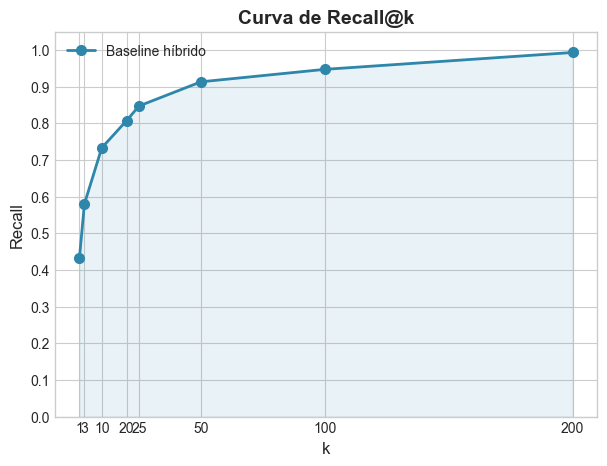

In [74]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("seaborn-v0_8-whitegrid")

recall_values = {
    1: 0.433,
    3: 0.580,
    10: 0.733,
    20: 0.807,
    25: 0.847,
    50: 0.913,
    100: 0.947,
    200: 0.993,
}

ks = list(recall_values.keys())
vals = list(recall_values.values())

plt.figure(figsize=(7,5))
plt.plot(ks, vals, marker="o", linewidth=2, markersize=7, color="#2E86AB", label="Baseline híbrido")
plt.fill_between(ks, vals, alpha=0.1, color="#2E86AB")
plt.title("Curva de Recall@k", fontsize=14, fontweight="bold")
plt.xlabel("k", fontsize=12)
plt.ylabel("Recall", fontsize=12)
plt.xticks(ks, fontsize=10)
plt.yticks(np.linspace(0,1,11), fontsize=10)
plt.ylim(0,1.05)
plt.legend(frameon=False)
plt.show()


In [69]:
import os, json

DATA_PATH = "../data/eval"
TOPK_PATH = "../data/normative/topk"
os.makedirs(TOPK_PATH, exist_ok=True)

TOP_K = 25
ALPHA = 0.3

with open(os.path.join(DATA_PATH, "qa_eval_set.json"), "r", encoding="utf-8") as f:
    qa_eval_set = json.load(f)

queries_dict, gold_labels = {}, {}
for i, entry in enumerate(qa_eval_set, start=1):
    qid = f"q{i}"
    queries_dict[qid] = entry["pregunta"]
    gold_labels[qid] = entry["relevant_chunks"]

def lexical_overlap(query, chunk):
    q_tokens, c_tokens = set(query.lower().split()), set(chunk.lower().split())
    return len(q_tokens & c_tokens) / len(q_tokens) if q_tokens else 0.0

rows, queries_missing = [], []

for query_id, query_text in queries_dict.items():
    relevant_chunks = gold_labels[query_id]

    q = preprocess(query_text)
    bm25_scores = bm25.get_scores(q.split())
    q_emb = mpnet_model.encode([q])
    D, I = faiss_index.search(q_emb, len(texts))
    mpnet_scores = np.zeros(len(texts))
    for idx, score in zip(I[0], D[0]):
        mpnet_scores[idx] = float(score)
    hybrid_scores = ALPHA * mpnet_scores + (1-ALPHA) * bm25_scores
    ranked = np.argsort(-hybrid_scores)[:TOP_K]

    if not any(rc in ranked for rc in relevant_chunks):
        queries_missing.append(query_id)

    gap_top1_top2 = hybrid_scores[ranked[0]] - hybrid_scores[ranked[1]] if len(ranked) >= 2 else hybrid_scores[ranked[0]]

    for rank, idx in enumerate(ranked, start=1):
        rows.append({
            "query_id": query_id,
            "chunk_id": idx,
            "bm25_score": bm25_scores[idx],
            "cosine_qc": mpnet_scores[idx],
            "hybrid_score": hybrid_scores[idx],
            "rank": rank,
            "gap_top1_top2": gap_top1_top2,
            "lexical_overlap": lexical_overlap(query_text, texts[idx]),
            "tokens_count_q": len(query_text.split()),
            "tokens_count_c": len(texts[idx].split()),
            "label_relevance": 1 if idx in relevant_chunks else 0
        })

df = pd.DataFrame(rows)
out_path = os.path.join(TOPK_PATH, "topk_candidates.csv")
df.to_csv(out_path, index=False)

print("Dataset generado:", df.shape)
print("Columnas:", df.columns.tolist())
print(f"Queries sin positivo en top-{TOP_K}: {len(queries_missing)} de {len(queries_dict)}")
print("Ejemplos:", queries_missing[:10])




Dataset generado: (3750, 11)
Columnas: ['query_id', 'chunk_id', 'bm25_score', 'cosine_qc', 'hybrid_score', 'rank', 'gap_top1_top2', 'lexical_overlap', 'tokens_count_q', 'tokens_count_c', 'label_relevance']
Queries sin positivo en top-25: 23 de 150
Ejemplos: ['q14', 'q29', 'q43', 'q47', 'q48', 'q50', 'q69', 'q71', 'q73', 'q74']


In [122]:
import pandas as pd, numpy as np, os, pickle, json
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import average_precision_score

CSV_PATH = "../data/normative/topk/topk_candidates.csv"
EVAL_PATH = "../data/eval/qa_eval_set.json"
CHUNKS_META_PATH = "../data/chunks/metadata.json"
MODELS_PATH = "../models/reranker"
os.makedirs(MODELS_PATH, exist_ok=True)

# Cargar datos
df = pd.read_csv(CSV_PATH)
print("Dataset:", df.shape)

with open(EVAL_PATH, "r", encoding="utf-8") as f:
    qa_eval_set = json.load(f)
with open(CHUNKS_META_PATH, "r", encoding="utf-8") as f:
    chunk_metadata = json.load(f)

feature_cols = [
    "bm25_score","cosine_qc","hybrid_score","rank",
    "gap_top1_top2","lexical_overlap","tokens_count_q","tokens_count_c"
]
X, y, qids = df[feature_cols].values, df["label_relevance"].values, df["query_id"].values

# Train/Test split
unique_qids = np.unique(qids)
train_qids, test_qids = train_test_split(unique_qids, test_size=0.2, random_state=42)
train_mask, test_mask = np.isin(qids, train_qids), np.isin(qids, test_qids)

scaler = StandardScaler()
X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test, qids_test = X[test_mask], y[test_mask], qids[test_mask]

X_train_s, X_test_s = scaler.fit_transform(X_train), scaler.transform(X_test)

clf = LogisticRegression(class_weight="balanced", max_iter=200, random_state=42)
clf.fit(X_train_s, y_train)

#  Evaluación
def evaluate_split(X_test_s, y_test, qids_test, clf, k=3):
    results = []
    for q in np.unique(qids_test):
        mask = qids_test == q
        y_true_q, y_scores_q = y_test[mask], clf.predict_proba(X_test_s[mask])[:,1]
        ranked = np.argsort(-y_scores_q)

        precision = 1 if any(y_true_q[i] == 1 for i in ranked[:k]) else 0
        recall = precision

        mrr = next((1.0/r for r,i in enumerate(ranked,1) if y_true_q[i]==1), 0.0)

        gains = y_true_q[ranked[:k]]
        ideal_gains = sorted(y_true_q, reverse=True)[:k]
        dcg = sum(g/np.log2(i+2) for i,g in enumerate(gains))
        idcg = sum(g/np.log2(i+2) for i,g in enumerate(ideal_gains))
        ndcg = dcg / idcg if idcg > 0 else 0.0

        map_score = average_precision_score(y_true_q, y_scores_q) if 1 in y_true_q else 0.0

        df_q = df[df["query_id"] == q]
        df_q = df_q.reset_index(drop=True)
        topk_idx = ranked[:k]
        pdfs_topk = set(chunk_metadata[df_q.iloc[i]["chunk_id"]]["pdf"] for i in topk_idx)

        pdfs_relevant = {qa_eval_set[int(q[1:])-1]["pdf"]}
        pdf_match = int(len(pdfs_topk & pdfs_relevant) > 0)

        results.append((precision, recall, ndcg, map_score, mrr, pdf_match))
    return np.mean(results, axis=0)


prec, rec, ndcg, map_score, mrr_score, pdf_match = evaluate_split(X_test_s, y_test, qids_test, clf, k=3)
print("\n--- Resultados en test (20%) ---")
print(f"K=3\n  precision: {prec:.3f}\n  recall: {rec:.3f}\n  ndcg: {ndcg:.3f}\n  map: {map_score:.3f}\n  mrr: {mrr_score:.3f}\n  pdf_match: {pdf_match:.3f}")

#  K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
metrics = []
for fold,(train_idx,test_idx) in enumerate(kf.split(unique_qids), start=1):
    train_q, test_q = unique_qids[train_idx], unique_qids[test_idx]
    train_mask, test_mask = np.isin(qids, train_q), np.isin(qids, test_q)

    X_train,y_train = X[train_mask],y[train_mask]
    X_test,y_test,qids_val = X[test_mask],y[test_mask],qids[test_mask]
    X_train_s,X_test_s = scaler.fit_transform(X_train),scaler.transform(X_test)

    clf_cv = LogisticRegression(class_weight="balanced", max_iter=200).fit(X_train_s,y_train)
    fold_scores = evaluate_split(X_test_s, y_test, qids_val, clf_cv, k=3)
    metrics.append(fold_scores)

    print(f"Fold {fold} → P={fold_scores[0]:.3f}, Rec={fold_scores[1]:.3f}, nDCG={fold_scores[2]:.3f}, MAP={fold_scores[3]:.3f}, MRR={fold_scores[4]:.3f}, PDF={fold_scores[5]:.3f}")

metrics = np.mean(metrics,axis=0)
print("\n--- Resultados medios (5-Fold) ---")
print(f"K=3\n  precision: {metrics[0]:.3f}\n  recall: {metrics[1]:.3f}\n  ndcg: {metrics[2]:.3f}\n  map: {metrics[3]:.3f}\n  mrr: {metrics[4]:.3f}\n  pdf_match: {metrics[5]:.3f}")

# entreno
X_scaled = scaler.fit_transform(X)
final_clf = LogisticRegression(class_weight="balanced", max_iter=200).fit(X_scaled, y)

with open(os.path.join(MODELS_PATH,"reranker.pkl"),"wb") as f: pickle.dump(final_clf,f)
with open(os.path.join(MODELS_PATH,"scaler.pkl"),"wb") as f: pickle.dump(scaler,f)
with open(os.path.join(MODELS_PATH,"features_schema.json"),"w") as f: json.dump(feature_cols,f)

print(f"\nModelo final entrenado y guardado en {MODELS_PATH}")


Dataset: (3750, 11)

--- Resultados en test (20%) ---
K=3
  precision: 0.800
  recall: 0.800
  ndcg: 0.742
  map: 0.743
  mrr: 0.743
  pdf_match: 1.000
Fold 1 → P=0.800, Rec=0.800, nDCG=0.742, MAP=0.743, MRR=0.743, PDF=1.000
Fold 2 → P=0.700, Rec=0.700, nDCG=0.646, MAP=0.637, MRR=0.637, PDF=1.000
Fold 3 → P=0.733, Rec=0.733, nDCG=0.630, MAP=0.622, MRR=0.622, PDF=1.000
Fold 4 → P=0.667, Rec=0.667, nDCG=0.609, MAP=0.615, MRR=0.615, PDF=1.000
Fold 5 → P=0.433, Rec=0.433, nDCG=0.367, MAP=0.387, MRR=0.387, PDF=1.000

--- Resultados medios (5-Fold) ---
K=3
  precision: 0.667
  recall: 0.667
  ndcg: 0.599
  map: 0.601
  mrr: 0.601
  pdf_match: 1.000

Modelo final entrenado y guardado en ../models/reranker


#### Comparación baseline híbrido vs. re-ranker (K=3)

| Sistema             | Precision | Recall | nDCG  | MAP   | MRR   | PDF Match |
|---------------------|-----------|--------|-------|-------|-------|-----------|
| Híbrido (baseline)  | 0.667 | 0.667  | 0.582 | 0.553 | 0.553 | 0.993 |
| Re-ranker           | **0.800**     | **0.800**  | **0.742** | **0.743** | **0.743** | **1.000**  |


Al comparar el baseline híbrido con el re-ranker:

- Mejoran mucho el **recall** (0.667 → 0.800) y el resto de métricas como nDCG, MAP y MRR.  
- Esto significa que el re-ranker consigue traer más veces el chunk correcto dentro del top-3, aunque no siempre lo priorice en primer lugar.

El re-ranker es una capa extra que hace el sistema más **robusto y fiable** (menos riesgo de perder el relevante).



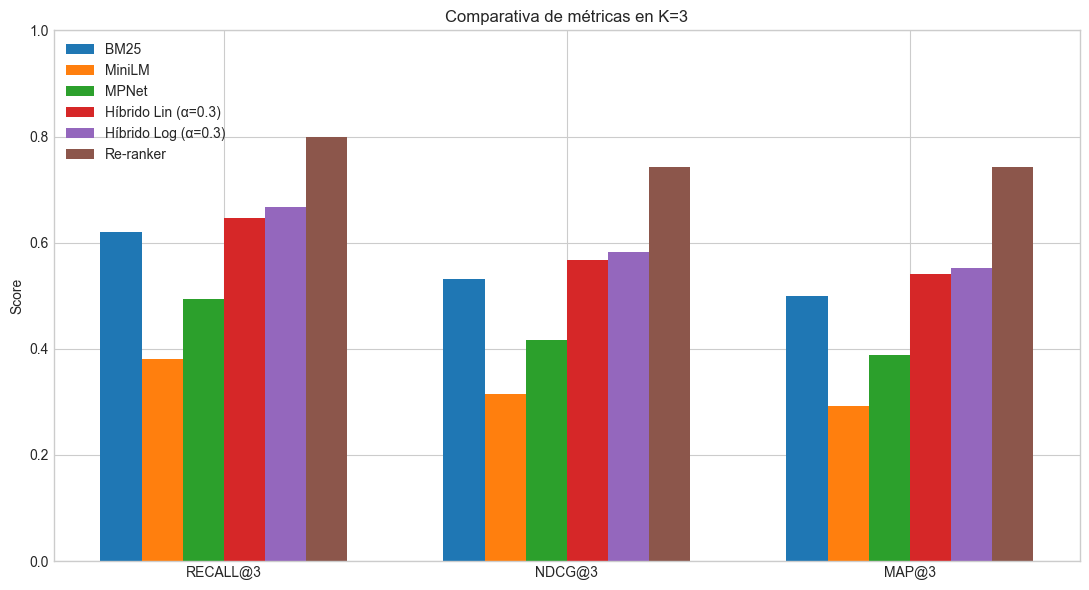

In [ ]:
import matplotlib.pyplot as plt

resultados = {
    "BM25":      {"recall":0.620, "ndcg":0.531, "map":0.500},
    "MiniLM":    {"recall":0.380, "ndcg":0.315, "map":0.293},
    "MPNet":     {"recall":0.493, "ndcg":0.416, "map":0.389},
    "Híbrido Lin (α=0.3)": {"recall":0.647, "ndcg":0.568, "map":0.541},
    "Híbrido Log (α=0.3)": {"recall":0.667, "ndcg":0.582, "map":0.553},
    "Re-ranker": {"recall":0.800, "ndcg":0.742, "map":0.743}
}

metricas = ["recall", "ndcg", "map"]
x = np.arange(len(metricas))
bar_width = 0.12

plt.figure(figsize=(11,6))

for i, (sistema, vals) in enumerate(resultados.items()):
    valores = [vals[m] for m in metricas]
    plt.bar(x + i*bar_width, valores, width=bar_width, label=sistema)

plt.xticks(x + bar_width*2.5, [m.upper()+"@3" for m in metricas])
plt.ylabel('Score')
plt.ylim(0, 1)
plt.title('Comparativa de métricas en K=3')
plt.legend()
plt.tight_layout()
plt.show()


### 6.2 Calibrador de confianza (Opción C)  
Aquí entrenamos otro modelo ligero que decide si la respuesta generada es fiable o no.  
Si el calibrador estima que la respuesta es buena, la mostramos. Si no, el sistema se abstiene y devuelve un mensaje estándar, indicando que no hay evidencia suficiente en las fuentes.  
Esto añade una capa de seguridad y transparencia: no siempre es mejor responder, a veces es mejor reconocer la incertidumbre.

In [ ]:
import os, json, pandas as pd
from tqdm import tqdm
from bert_score import score as bertscore

GEN_PATH = "../data/normative/generations"
os.makedirs(GEN_PATH, exist_ok=True)

with open("../data/eval/qa_eval_set.json", "r", encoding="utf-8") as f:
    qa_eval_set = json.load(f)

rows = []
for i, entry in enumerate(tqdm(qa_eval_set, desc="Generando respuestas")):
    qid = f"q{i+1}"
    query_text = entry["pregunta"]
    gold = entry["respuesta_esperada"]
    relevant_chunks = entry["relevant_chunks"]
    pdf_gold = entry["pdf"]

    # Recuperar top-3
    cands = hybrid_retrieval(query_text, alpha=0.3, top_k=3)
    top1, top2 = cands[0], cands[1] if len(cands) > 1 else (cands[0], None)

    max_hybrid_score = top1["score"]
    gap_top1_top2 = max_hybrid_score - (top2["score"] if top2 else 0)
    cosine_top1 = top1["meta"].get("cosine_score", 0.0)

    # Prompt y generación
    prompt = build_prompt(query_text, cands)
    response = generate_response(prompt)

    # Features del prompt
    k_in_prompt = len(cands)
    prompt_tokens = len(prompt.split())

    # PDF match (si el pdf de top-1 coincide con el gold)
    has_pdf_match = 1 if top1["meta"]["pdf"] == pdf_gold else 0

    P, R, F1 = bertscore([response], [gold], lang="en")
    bert_f1 = float(F1[0])

    #  BUENA/MALA
    label_quality = 1 if (has_pdf_match == 1 and bert_f1 >= 0.7) else 0

    rows.append({
        "query_id": qid,
        "query": query_text,
        "response": response,
        "gold": gold,
        "max_hybrid_score": max_hybrid_score,
        "gap_top1_top2": gap_top1_top2,
        "cosine_top1": cosine_top1,
        "k_in_prompt": k_in_prompt,
        "prompt_tokens": prompt_tokens,
        "has_pdf_match": has_pdf_match,
        "bertscore_f1": bert_f1,
        "label_quality": label_quality
    })

df = pd.DataFrame(rows)
out_path = os.path.join(GEN_PATH, "generations_log.csv")
df.to_csv(out_path, index=False)
print(f"Log guardado en {out_path}, con {len(df)} respuestas")
print("Distribución BUENA/MALA:\n", df["label_quality"].value_counts())


Generando respuestas:   0%|          | 0/150 [00:00<?, ?it/s]Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:  15%|#4        | 241M/1.66G [00:00<?, ?B/s]

d:\TFM_RAG_NOR\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\aalex\.cache\huggingface\hub\models--roberta-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.b

Log guardado en ../data/normative/generations\generations_log.csv, con 150 respuestas
Distribución BUENA/MALA:
 label_quality
1    131
0     19
Name: count, dtype: int64


#### El dataset está desbalanceado (131 buenas vs 19 malas). Para solventarlo añadimos manualmente algunos ejemplos fuera de dominio.

In [79]:
import pandas as pd, os
from tqdm import tqdm

# Cargar dataset original
df = pd.read_csv("../data/normative/generations/generations_log.csv")
print("Distribución original:\n", df["label_quality"].value_counts())

# Submuestreo de BUENAS a 100
df_good = df[df["label_quality"] == 1].sample(n=100, random_state=42)
df_bad = df[df["label_quality"] == 0]
df_base = pd.concat([df_good, df_bad], ignore_index=True)

print("Tras undersampling:\n", df_base["label_quality"].value_counts())

# Queries manuales
extra_queries = [
    "What is the capital of Mars?",
    "Give me the recipe for Spanish paella",
    "Who won the FIFA World Cup in 1998?",
    "What is the square root of 12345?",
    "Tell me about the movie Titanic",
    "Translate 'hello' into Japanese",
    "How do you bake a chocolate cake?",
    "What is the weather in New York tomorrow?",
    "Explain quantum physics to a child",
    "List the planets in the Solar System",
    "How tall is Mount Everest?",
    "Who discovered penicillin?",
    "Play me a song by The Beatles",
    "What time is it in Tokyo right now?",
    "Give me the history of Minecraft",
    "Who painted the Mona Lisa?",
    "Write a haiku about pizza",
    "Name the main characters in Harry Potter",
    "What is the formula for water?",
    "Show me the stock price of Apple",
    "Tell me a joke about computers",
    "When was the first iPhone released?",
    "Who is the current US president?",
    "What does CPU stand for?",
    "How many continents are there?",
    "Recite the alphabet backwards",
    "What is the national dish of Italy?",
    "When is Christmas celebrated?",
    "Who invented the airplane?",
    "How far is the Moon from Earth?",
    "Who is the best football player in history?",
    "What is the boiling point of gold?",
    "Sing me a lullaby",
    "What is the meaning of life?",
    "Write me a poem about dragons",
    "How to fix a leaking faucet?",
    "Give me the lyrics of a Beatles song",
    "What is the capital of Wakanda?",
    "Show me pictures of cats",
    "Who directed the movie Avatar?",
    "What is 12345 multiplied by 6789?",
    "What is the currency of Middle Earth?",
    "Give me the horoscope for tomorrow",
    "What is the color of happiness?",
    "How many letters are in the alphabet?",
    "What is the oldest city in the world?",
    "How do you make sushi?",
    "Who wrote Don Quixote?",
    "Explain black holes to a 5-year-old",
    "Give me the current Bitcoin price"
]

rows_extra = []
for i, query_text in enumerate(tqdm(extra_queries, desc="Generando respuestas extra")):
    cands = hybrid_retrieval(query_text, alpha=0.3, top_k=3)
    top1, top2 = cands[0], cands[1] if len(cands) > 1 else (cands[0], None)

    max_hybrid_score = top1["score"]
    gap_top1_top2 = max_hybrid_score - (top2["score"] if top2 else 0)
    cosine_top1 = top1["meta"].get("cosine_score", 0.0)

    prompt = build_prompt(query_text, cands)
    response = generate_response(prompt)

    k_in_prompt = len(cands)
    prompt_tokens = len(prompt.split())
    has_pdf_match = 0
    bert_f1 = 0.0
    label_quality = 0

    rows_extra.append({
        "query_id": f"extra_{i+1}",
        "query": query_text,
        "response": response,
        "gold": "N/A",
        "max_hybrid_score": max_hybrid_score,
        "gap_top1_top2": gap_top1_top2,
        "cosine_top1": cosine_top1,
        "k_in_prompt": k_in_prompt,
        "prompt_tokens": prompt_tokens,
        "has_pdf_match": has_pdf_match,
        "bertscore_f1": bert_f1,
        "label_quality": label_quality
    })

df_extra = pd.DataFrame(rows_extra)

df_final = pd.concat([df_base, df_extra], ignore_index=True)

out_path = "../data/normative/generations/generations_log_balanced.csv"
df_final.to_csv(out_path, index=False)

print(f"Dataset balanceado guardado en {out_path}")
print("Distribución final:\n", df_final['label_quality'].value_counts())



Distribución original:
 label_quality
1    131
0     19
Name: count, dtype: int64
Tras undersampling:
 label_quality
1    100
0     19
Name: count, dtype: int64


Generando respuestas extra: 100%|██████████| 50/50 [09:52<00:00, 11.85s/it]

Dataset balanceado guardado en ../data/normative/generations/generations_log_balanced.csv
Distribución final:
 label_quality
1    100
0     69
Name: count, dtype: int64


In [81]:
df = pd.read_csv("../data/normative/generations/generations_log_balanced.csv")

# Seleccionar features y label
feature_cols = [
    "max_hybrid_score","gap_top1_top2","cosine_top1",
    "k_in_prompt","prompt_tokens","has_pdf_match","bertscore_f1"
]

corrs = {}
for col in feature_cols:
    corr = df[col].corr(df["label_quality"])
    corrs[col] = corr

# correlaciones ordenadas
corrs_sorted = dict(sorted(corrs.items(), key=lambda x: abs(x[1]), reverse=True))
print("Correlaciones con label_quality:")
for k, v in corrs_sorted.items():
    print(f"{k}: {v:.3f}")


Correlaciones con label_quality:
cosine_top1: nan
k_in_prompt: nan
has_pdf_match: 0.988
bertscore_f1: 0.789
max_hybrid_score: 0.746
gap_top1_top2: 0.376
prompt_tokens: 0.200


d:\TFM_RAG_NOR\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
d:\TFM_RAG_NOR\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [111]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

CSV_PATH = "../data/normative/generations/generations_log_balanced.csv"
MODELS_PATH = "../models/calibrator"
os.makedirs(MODELS_PATH, exist_ok=True)

df = pd.read_csv(CSV_PATH)
print("Dataset balanceado:", df.shape)
print("Distribución:\n", df["label_quality"].value_counts())

feature_cols = [
    "max_hybrid_score","gap_top1_top2",
    "k_in_prompt","prompt_tokens"
]
X, y = df[feature_cols].values, df["label_quality"].values

scaler = StandardScaler()

#  Train/Test split (80/20 estratificado)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train_s, X_test_s = scaler.fit_transform(X_train), scaler.transform(X_test)

clf = LogisticRegression(class_weight="balanced", max_iter=500, random_state=42)
clf.fit(X_train_s, y_train)

y_pred = clf.predict(X_test_s)
y_proba = clf.predict_proba(X_test_s)[:,1]

print("\n--- Resultados en test (20%) ---")
print(f"Acc={accuracy_score(y_test,y_pred):.3f}")
print(f"Prec={precision_score(y_test,y_pred,zero_division=0):.3f}")
print(f"Rec={recall_score(y_test,y_pred,zero_division=0):.3f}")
print(f"F1={f1_score(y_test,y_pred,zero_division=0):.3f}")
print(f"AUC={roc_auc_score(y_test,y_proba):.3f}")

# Kfolds
kf = KFold(n_splits=5, shuffle=True, random_state=42)
metrics = []

for fold,(train_idx,test_idx) in enumerate(kf.split(X), start=1):
    X_tr, X_val = X[train_idx], X[test_idx]
    y_tr, y_val = y[train_idx], y[test_idx]
    X_tr_s, X_val_s = scaler.fit_transform(X_tr), scaler.transform(X_val)

    clf_cv = LogisticRegression(class_weight="balanced", max_iter=500, random_state=42)
    clf_cv.fit(X_tr_s, y_tr)

    y_val_pred = clf_cv.predict(X_val_s)
    y_val_proba = clf_cv.predict_proba(X_val_s)[:,1]

    acc = accuracy_score(y_val,y_val_pred)
    prec = precision_score(y_val,y_val_pred,zero_division=0)
    rec = recall_score(y_val,y_val_pred,zero_division=0)
    f1 = f1_score(y_val,y_val_pred,zero_division=0)
    auc = roc_auc_score(y_val,y_val_proba)

    metrics.append((acc,prec,rec,f1,auc))
    print(f"Fold {fold} → Acc={acc:.3f}, Prec={prec:.3f}, Rec={rec:.3f}, F1={f1:.3f}, AUC={auc:.3f}")

metrics = np.mean(metrics,axis=0)
print("\n--- Resultados medios (5-Fold) ---")
print(f"Acc={metrics[0]:.3f}, Prec={metrics[1]:.3f}, Rec={metrics[2]:.3f}, F1={metrics[3]:.3f}, AUC={metrics[4]:.3f}")

# Enteno
X_scaled = scaler.fit_transform(X)
final_clf = LogisticRegression(class_weight="balanced", max_iter=500, random_state=42)
final_clf.fit(X_scaled,y)

with open(os.path.join(MODELS_PATH,"calibrator.pkl"),"wb") as f: pickle.dump(final_clf,f)
with open(os.path.join(MODELS_PATH,"scaler.pkl"),"wb") as f: pickle.dump(scaler,f)
with open(os.path.join(MODELS_PATH,"features_schema.json"),"w") as f: json.dump(feature_cols,f)

print(f"\nCalibrador entrenado y guardado en {MODELS_PATH}")



Dataset balanceado: (169, 12)
Distribución:
 label_quality
1    100
0     69
Name: count, dtype: int64

--- Resultados en test (20%) ---
Acc=0.912
Prec=0.905
Rec=0.950
F1=0.927
AUC=0.954
Fold 1 → Acc=0.882, Prec=0.909, Rec=0.909, F1=0.909, AUC=0.898
Fold 2 → Acc=0.882, Prec=0.905, Rec=0.905, F1=0.905, AUC=0.956
Fold 3 → Acc=0.824, Prec=0.810, Rec=0.895, F1=0.850, AUC=0.930
Fold 4 → Acc=0.882, Prec=0.900, Rec=0.900, F1=0.900, AUC=0.954
Fold 5 → Acc=0.848, Prec=0.810, Rec=0.944, F1=0.872, AUC=0.926

--- Resultados medios (5-Fold) ---
Acc=0.864, Prec=0.867, Rec=0.911, F1=0.887, AUC=0.933

Calibrador entrenado y guardado en ../models/calibrator


In [112]:

print(" Pesos del calibrador")
for f, w in zip(feature_cols, final_clf.coef_[0]):
    print(f"{f}: {w:.3f}")

print("\nEjemplos de predicciones")
for i in range(10):
    x = X_test_s[i].reshape(1, -1)
    proba = final_clf.predict_proba(x)[0,1]
    pred = final_clf.predict(x)[0]
    print(f"Query {i+1}: Proba={proba:.3f}, Pred={pred}, Real={y_test[i]}")


 Pesos del calibrador
max_hybrid_score: 2.583
gap_top1_top2: 0.548
k_in_prompt: 0.000
prompt_tokens: -0.105

Ejemplos de predicciones
Query 1: Proba=0.233, Pred=0, Real=0
Query 2: Proba=0.986, Pred=1, Real=1
Query 3: Proba=0.938, Pred=1, Real=1
Query 4: Proba=0.108, Pred=0, Real=0
Query 5: Proba=0.024, Pred=0, Real=0
Query 6: Proba=0.042, Pred=0, Real=0
Query 7: Proba=0.770, Pred=1, Real=1
Query 8: Proba=0.851, Pred=1, Real=1
Query 9: Proba=0.640, Pred=1, Real=1
Query 10: Proba=0.895, Pred=1, Real=1


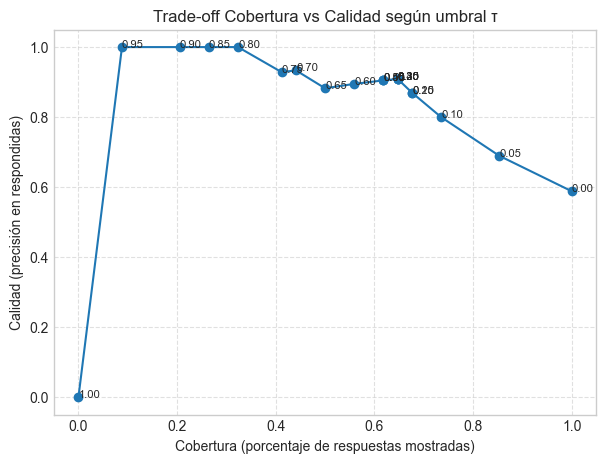

Umbral óptimo τ (según F1): 0.25


In [113]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

y_proba = clf.predict_proba(X_test_s)[:,1]

taus = np.linspace(0, 1, 21)  # umbrales de 0 a 1 en pasos de 0.05
coverage, quality, f1_scores = [], [], []

for tau in taus:
    preds = (y_proba >= tau).astype(int)
    
    # Cobertura: % de respuestas que se muestran
    cov = (preds == 1).mean()
    
    # Calidad: precisión entre las respuestas que sí se muestran
    if preds.sum() > 0:
        q = (y_test[preds == 1] == 1).mean()
    else:
        q = 0.0
    
    f1 = f1_score(y_test, preds, zero_division=0)
    
    coverage.append(cov)
    quality.append(q)
    f1_scores.append(f1)

plt.figure(figsize=(7,5))
plt.plot(coverage, quality, marker="o")
for t,c,q in zip(taus, coverage, quality):
    plt.text(c, q, f"{t:.2f}", fontsize=8)
plt.xlabel("Cobertura (porcentaje de respuestas mostradas)")
plt.ylabel("Calidad (precisión en respondidas)")
plt.title("Trade-off Cobertura vs Calidad según umbral τ")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

#  τ / F1
best_tau = taus[np.argmax(f1_scores)]
print(f"Umbral óptimo τ (según F1): {best_tau:.2f}")


### 6.3 Demo + calibrador

In [130]:
# build_chunk_embeddings.py
import os, json, numpy as np
from sentence_transformers import SentenceTransformer

DATA_PATH = "../data"
EMB_DIR = os.path.join(DATA_PATH, "embeddings")
os.makedirs(EMB_DIR, exist_ok=True)

MODEL_NAME = "sentence-transformers/all-mpnet-base-v2"

with open(os.path.join(DATA_PATH, "chunks", "texts.json"), "r", encoding="utf-8") as f:
    texts = json.load(f)

model = SentenceTransformer(MODEL_NAME)
embs = model.encode(texts, batch_size=128, convert_to_numpy=True, normalize_embeddings=True, show_progress_bar=True)
np.save(os.path.join(EMB_DIR, "mpnet_embeddings.npy"), embs)
print("Saved:", embs.shape)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Saved: (357, 768)


In [133]:
# === SETUP RAG + RE-RANKER + CALIBRADOR ===
import os, json, pickle, faiss, numpy as np
from typing import List, Dict, Any
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
from openai import OpenAI

DATA_PATH   = "../data"
MODELS_PATH = "../models"
EMB_DIR     = os.path.join(DATA_PATH, "embeddings")

HYBRID_ALPHA   = 0.3
POOL_K         = 25
TOP_K          = 3
CALIBRATOR_TAU = 0.25
GEN_MODEL      = "llama-3.1-8b-instant"

# corpus / indices
with open(os.path.join(DATA_PATH, "bm25", "bm25_index.pkl"), "rb") as f:
    bm25 = pickle.load(f)
faiss_index = faiss.read_index(os.path.join(DATA_PATH, "faiss_index", "faiss_index_mpnet.faiss"))
with open(os.path.join(DATA_PATH, "chunks", "texts.json"), "r", encoding="utf-8") as f:
    texts: List[str] = json.load(f)
with open(os.path.join(DATA_PATH, "chunks", "metadata.json"), "r", encoding="utf-8") as f:
    metadata: List[Dict[str, Any]] = json.load(f)
chunk_embs = np.load(os.path.join(EMB_DIR, "mpnet_embeddings.npy"))

# modelos
mpnet_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
client = OpenAI(api_key="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", base_url="https://api.groq.com/openai/v1")

with open(os.path.join(MODELS_PATH, "reranker", "reranker.pkl"), "rb") as f:
    reranker = pickle.load(f)
with open(os.path.join(MODELS_PATH, "reranker", "scaler.pkl"), "rb") as f:
    rr_scaler: StandardScaler = pickle.load(f)
with open(os.path.join(MODELS_PATH, "reranker", "features_schema.json"), "r", encoding="utf-8") as f:
    rr_feature_cols: List[str] = json.load(f)

with open(os.path.join(MODELS_PATH, "calibrator", "calibrator.pkl"), "rb") as f:
    calibrator = pickle.load(f)
with open(os.path.join(MODELS_PATH, "calibrator", "scaler.pkl"), "rb") as f:
    cal_scaler: StandardScaler = pickle.load(f)
with open(os.path.join(MODELS_PATH, "calibrator", "features_schema.json"), "r", encoding="utf-8") as f:
    cal_feature_cols: List[str] = json.load(f)

# utils
def preprocess(s: str): return s.lower().strip()
def tokenize_simple(s: str): return [t for t in preprocess(s).split() if t.isalpha()]
def lexical_overlap(q, c):
    qs, cs = set(tokenize_simple(q)), set(tokenize_simple(c))
    return 0.0 if not qs or not cs else len(qs & cs) / len(qs | cs)

# retrieval pool
def hybrid_candidate_pool(query, alpha=HYBRID_ALPHA, pool_k=POOL_K):
    q = preprocess(query)
    bm25_scores = bm25.get_scores(q.split()).astype(np.float32)
    q_emb = mpnet_model.encode([q], convert_to_numpy=True, normalize_embeddings=True)
    D, I = faiss_index.search(q_emb, len(texts))
    mpnet_scores = np.zeros(len(texts), dtype=np.float32)
    mpnet_scores[I[0]] = D[0].astype(np.float32)
    hybrid_scores = alpha * mpnet_scores + (1.0 - alpha) * bm25_scores
    ranked = np.argsort(-hybrid_scores)[:pool_k]
    return ranked, bm25_scores, mpnet_scores, hybrid_scores, q_emb

# re-ranker
def build_reranker_features(query, cand_idx, bm25_s, mpnet_s, q_emb, alpha=HYBRID_ALPHA):
    cos_qc = (q_emb @ chunk_embs[cand_idx].T)[0].astype(np.float32)
    hybrid_vals = alpha * mpnet_s[cand_idx] + (1.0 - alpha) * bm25_s[cand_idx]
    gap = float(hybrid_vals[0] - hybrid_vals[1]) if len(cand_idx) > 1 else float(hybrid_vals[0])
    feats = []
    for r, (idx, cosv, hv) in enumerate(zip(cand_idx, cos_qc, hybrid_vals)):
        feats.append({
            "bm25_score": float(bm25_s[idx]),
            "cosine_qc": float(cosv),
            "hybrid_score": float(hv),
            "rank": r + 1,
            "gap_top1_top2": gap if r == 0 else 0.0,
            "lexical_overlap": lexical_overlap(query, texts[int(idx)]),
            "tokens_count_q": len(tokenize_simple(query)),
            "tokens_count_c": len(tokenize_simple(texts[int(idx)])),
            "_idx": int(idx)
        })
    X = np.array([[f[c] for c in rr_feature_cols] for f in feats], dtype=np.float32)
    return X, feats

def retrieve_then_rerank(query, alpha=HYBRID_ALPHA, pool_k=POOL_K, top_k=TOP_K):
    cand_idx, bm25_s, mpnet_s, hybrid_s, q_emb = hybrid_candidate_pool(query, alpha=alpha, pool_k=pool_k)
    X, feats = build_reranker_features(query, cand_idx, bm25_s, mpnet_s, q_emb, alpha=alpha)
    probs = reranker.predict_proba(rr_scaler.transform(X))[:, 1]
    order = np.argsort(-probs)[:top_k]
    selected = []
    for j in order:
        idx = feats[j]["_idx"]
        selected.append({"_idx": idx, "chunk": texts[idx], "meta": metadata[idx], "rerank_score": float(probs[j])})
    hybrid_selected = [float(hybrid_s[s["_idx"]]) for s in selected]
    return selected, hybrid_selected

# prompt / generación
def build_prompt(query, chunks):
    ctx = "\n\n".join([f"[Doc: {c['meta'].get('pdf','N/A')}, pages: {c['meta'].get('pages','?')}]\n{c['chunk']}" for c in chunks])
    return f"Question: {query}\n\nContext:\n{ctx}\n\nInstruction:\nAnswer the question using only the context above. If the answer is not in the documents, say clearly that it is not found."

def generate_response(prompt, model=GEN_MODEL, temperature=0.2, max_tokens=512):
    out = client.chat.completions.create(
        model=model,
        messages=[{"role":"system","content":"You are an assistant specialized in AI ethics and governance."},
                  {"role":"user","content":prompt}],
        temperature=temperature,
        max_tokens=max_tokens
    )
    return out.choices[0].message.content.strip()

# calibrador
def build_calibrator_features(chunks, prompt, hybrid_top):
    max_h = float(max(hybrid_top)) if hybrid_top else 0.0
    gap   = float(hybrid_top[0] - hybrid_top[1]) if len(hybrid_top) > 1 else max_h
    feats = {"max_hybrid_score": max_h, "gap_top1_top2": gap, "k_in_prompt": len(chunks), "prompt_tokens": len(prompt.split())}
    return np.array([[feats[c] for c in cal_feature_cols]], dtype=np.float32)

def calibrate(chunks, prompt, hybrid_top, tau=CALIBRATOR_TAU):
    Xs = cal_scaler.transform(build_calibrator_features(chunks, prompt, hybrid_top))
    p = float(calibrator.predict_proba(Xs)[:, 1][0])
    return (p >= tau), p




In [134]:
# === DEMO ===
while True:
    try:
        q = input("Escribe tu pregunta (o 'exit' para salir): ").strip()
    except (EOFError, KeyboardInterrupt):
        break
    if q.lower() == "exit":
        break
    if not q:
        continue

    chunks, hybrid_selected = retrieve_then_rerank(q, alpha=HYBRID_ALPHA, pool_k=POOL_K, top_k=TOP_K)
    prompt = build_prompt(q, chunks)
    resp = generate_response(prompt)

    ok, proba = calibrate(chunks, prompt, hybrid_selected, tau=CALIBRATOR_TAU)

    print("\n=== Query ===")
    print(q)

    print("\n=== Chunks seleccionados ===")
    for i, c in enumerate(chunks, 1):
        m = c["meta"]
        print(f"{i:02d}) Doc: {m.get('pdf','N/A')} | Pages: {m.get('pages','?')} | rerank_score: {c['rerank_score']:.4f}")

    print("\n=== Respuesta generada ===")
    print(resp)

    print("\n=== Calibrador ===")
    print(f"{'✔ Mostrar' if ok else '✖ Abstener'} (p={proba:.2f})")
    print("\n" + "="*60 + "\n")




=== Query ===
What is the main advisory responsibility of the European Artificial Intelligence Board according to the regulation?

=== Chunks seleccionados ===
01) Doc: eu_ai_act_regulation.pdf | Pages: [2] | rerank_score: 0.1465
02) Doc: eu_ai_act_regulation.pdf | Pages: [37] | rerank_score: 0.1162
03) Doc: eu_ai_act_regulation.pdf | Pages: [] | rerank_score: 0.0951

=== Respuesta generada ===
According to the provided context, the main advisory responsibility of the European Artificial Intelligence Board is to issue opinions, recommendations, advice or guidance on matters related to the implementation of the Regulation, including on technical specifications or existing standards regarding the requirements established in this Regulation, and to provide advice to and assist the Commission on specific questions related to artificial intelligence.

=== Calibrador ===
✔ Mostrar (p=0.70)



=== Query ===
Why does the document emphasize a holistic and systemic approach to achieving Trustwo

### Conclusión sobre el calibrador

El calibrador funciona como una capa adicional que ayuda a decidir si una respuesta generada es confiable o si conviene abstenerse.  
En la práctica responde bien en casos literales o muy claros, y suele abstenerse cuando la pregunta está fuera de dominio.  

Sin embargo, el dataset usado es pequeño y limitado, por lo que el calibrador no puede considerarse un modelo autónomo ni totalmente fiable.  
Es útil como apoyo y filtro de seguridad, pero siempre requiere verificación adicional para garantizar la calidad de las respuestas.
